<a href="https://colab.research.google.com/github/knkarthik01/polypharmacy-med-recommendation/blob/main/Medication_Recommendation_System_for_Polypharmacy_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medication Recommendation System for Polypharmacy Patients

This notebook presents a comprehensive approach to building a medication recommendation system for patients with multiple conditions (polypharmacy), which is a common challenge in healthcare. Traditional medication recommendation systems often focus on single diseases, but our approach addresses the complexity of patients with multiple conditions by using graph neural networks to model the relationships between patients, medications, and diagnoses.


## Step 1: Setup and Import Libraries

In [2]:
# Check PyTorch version
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Then install appropriate version
# For example, for PyTorch 2.1.0 with CUDA 11.8:
!pip install torch-geometric
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.4 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, to_hetero
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Step 2: Load and Explore MIMIC-III Data


In [5]:
# Load relevant MIMIC-III tables
# Replace these paths with your local MIMIC-III file locations
prescriptions_df = pd.read_csv('PRESCRIPTIONS.csv.gz')
diagnoses_df = pd.read_csv('DIAGNOSES_ICD.csv.gz')
patients_df = pd.read_csv('PATIENTS.csv.gz')
admissions_df = pd.read_csv('ADMISSIONS.csv.gz')

# Display the first few rows of each dataframe
print("Prescriptions Data:")
print(prescriptions_df.head())
print("\nDiagnoses Data:")
print(diagnoses_df.head())
print("\nPatients Data:")
print(patients_df.head())
print("\nAdmissions Data:")
print(admissions_df.head())

# Check the shape of each dataframe
print("\nDataset Shapes:")
print(f"Prescriptions: {prescriptions_df.shape}")
print(f"Diagnoses: {diagnoses_df.shape}")
print(f"Patients: {patients_df.shape}")
print(f"Admissions: {admissions_df.shape}")

Prescriptions Data:
    ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTDATE  \
0  2214776           6   107064         NaN  2175-06-11 00:00:00   
1  2214775           6   107064         NaN  2175-06-11 00:00:00   
2  2215524           6   107064         NaN  2175-06-11 00:00:00   
3  2216265           6   107064         NaN  2175-06-11 00:00:00   
4  2214773           6   107064         NaN  2175-06-11 00:00:00   

               ENDDATE DRUG_TYPE            DRUG DRUG_NAME_POE  \
0  2175-06-12 00:00:00      MAIN      Tacrolimus    Tacrolimus   
1  2175-06-12 00:00:00      MAIN        Warfarin      Warfarin   
2  2175-06-12 00:00:00      MAIN  Heparin Sodium           NaN   
3  2175-06-12 00:00:00      BASE             D5W           NaN   
4  2175-06-12 00:00:00      MAIN      Furosemide    Furosemide   

  DRUG_NAME_GENERIC FORMULARY_DRUG_CD     GSN          NDC  \
0        Tacrolimus             TACR1  021796  469061711.0   
1          Warfarin             WARF5  006562   56

## Step 3: Data Preprocessing and Cleaning


In [9]:
## Step 3: Data Preprocessing and Cleaning
# 3.1 Check for missing values
print("\nMissing Values:")
print(f"Prescriptions: {prescriptions_df.isnull().sum().sum()}")
print(f"Diagnoses: {diagnoses_df.isnull().sum().sum()}")
print(f"Patients: {patients_df.isnull().sum().sum()}")
print(f"Admissions: {admissions_df.isnull().sum().sum()}")

# 3.2 Clean and prepare prescription data
# Focus on essential columns and drop rows with missing critical values
essential_rx_columns = ['SUBJECT_ID', 'HADM_ID', 'DRUG', 'DOSE_VAL_RX', 'DOSE_UNIT_RX', 'ROUTE']
prescriptions_clean = prescriptions_df[essential_rx_columns].copy()
prescriptions_clean = prescriptions_clean.dropna(subset=['DRUG', 'SUBJECT_ID', 'HADM_ID'])

# Standardize medication names
prescriptions_clean['DRUG'] = prescriptions_clean['DRUG'].str.upper()
prescriptions_clean['DRUG'] = prescriptions_clean['DRUG'].str.strip()

# Handle missing dose information
prescriptions_clean['DOSE_VAL_RX'] = prescriptions_clean['DOSE_VAL_RX'].fillna(0)
prescriptions_clean['DOSE_UNIT_RX'] = prescriptions_clean['DOSE_UNIT_RX'].fillna('UNK')
prescriptions_clean['ROUTE'] = prescriptions_clean['ROUTE'].fillna('UNK')

# 3.3 Clean diagnoses data
# Keep only necessary columns and drop rows with missing ICD codes
essential_dx_columns = ['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']
diagnoses_clean = diagnoses_df[essential_dx_columns].copy()
diagnoses_clean = diagnoses_clean.dropna(subset=['ICD9_CODE', 'SUBJECT_ID', 'HADM_ID'])

# Standardize ICD9 codes
diagnoses_clean['ICD9_CODE'] = diagnoses_clean['ICD9_CODE'].astype(str)
# Ensure ICD9 codes have consistent formatting
diagnoses_clean['ICD9_CODE'] = diagnoses_clean['ICD9_CODE'].str.strip()
# Remove any decimal points that might be in some ICD codes
diagnoses_clean['ICD9_CODE'] = diagnoses_clean['ICD9_CODE'].str.replace('.', '')

# 3.4 Prepare patient demographic information
# Select relevant columns from patients and admissions
patients_clean = patients_df[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD']].copy()
admissions_clean = admissions_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']].copy()

# Fill missing gender values with 'Unknown'
patients_clean['GENDER'] = patients_clean['GENDER'].fillna('Unknown')

# 3.5 Calculate patient age at admission safely
# Convert date columns to datetime with error handling
patients_clean['DOB'] = pd.to_datetime(patients_clean['DOB'], errors='coerce')
admissions_clean['ADMITTIME'] = pd.to_datetime(admissions_clean['ADMITTIME'], errors='coerce')

# Merge patients and admissions
patient_admissions = pd.merge(
    patients_clean,
    admissions_clean,
    on='SUBJECT_ID',
    how='inner'
)

# Calculate age using year difference to avoid overflow errors
patient_admissions['BIRTH_YEAR'] = patient_admissions['DOB'].dt.year
patient_admissions['ADMIT_YEAR'] = patient_admissions['ADMITTIME'].dt.year
patient_admissions['AGE'] = patient_admissions['ADMIT_YEAR'] - patient_admissions['BIRTH_YEAR']

# Drop rows with missing or invalid ages
patient_admissions = patient_admissions.dropna(subset=['AGE'])
# Filter out unrealistic ages
patient_admissions = patient_admissions[(patient_admissions['AGE'] >= 0) & (patient_admissions['AGE'] <= 100)]

# 3.6 Add useful derived features
# Calculate length of stay
patient_admissions['DISCHTIME'] = pd.to_datetime(patient_admissions['DISCHTIME'], errors='coerce')
patient_admissions['LOS_DAYS'] = (patient_admissions['DISCHTIME'] - patient_admissions['ADMITTIME']).dt.total_seconds() / (60*60*24)
patient_admissions['LOS_DAYS'] = patient_admissions['LOS_DAYS'].clip(0, 365)  # Cap at 365 days to handle errors

# Determine mortality status during hospital stay
patient_admissions['DOD'] = pd.to_datetime(patient_admissions['DOD'], errors='coerce')
patient_admissions['MORTALITY'] = ~patient_admissions['DOD'].isna()

# 3.7 Create final cleaned dataframes for analysis
# Select only the columns we need for our analysis
prescriptions_final = prescriptions_clean.copy()
diagnoses_final = diagnoses_clean.copy()
patients_final = patient_admissions[['SUBJECT_ID', 'HADM_ID', 'GENDER', 'AGE', 'LOS_DAYS', 'MORTALITY']].copy()

# 3.8 Check for duplicate records and remove if necessary
prescriptions_final = prescriptions_final.drop_duplicates()
diagnoses_final = diagnoses_final.drop_duplicates()
patients_final = patients_final.drop_duplicates()

# 3.9 Print summary of cleaned data
print("\nCleaned Data Shapes:")
print(f"Prescriptions: {prescriptions_final.shape}")
print(f"Diagnoses: {diagnoses_final.shape}")
print(f"Patient-Admissions: {patients_final.shape}")

# 3.10 Check data quality after cleaning
def data_quality_check(df, name):
    print(f"\n{name} Data Quality Check:")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print(f"Number of unique patients: {df['SUBJECT_ID'].nunique()}")
    print(f"Number of unique admissions: {df['HADM_ID'].nunique()}")

data_quality_check(prescriptions_final, "Prescriptions")
data_quality_check(diagnoses_final, "Diagnoses")
data_quality_check(patients_final, "Patients")

# 3.11 Replace original dataframes with cleaned versions
prescriptions_clean = prescriptions_final
diagnoses_clean = diagnoses_final
patient_admissions = patients_final


Missing Values:
Prescriptions: 5305068
Diagnoses: 94
Patients: 100449
Admissions: 145263

Cleaned Data Shapes:
Prescriptions: (2544514, 6)
Diagnoses: (650940, 3)
Patient-Admissions: (56360, 6)

Prescriptions Data Quality Check:
Missing values: 0
Duplicate rows: 0
Number of unique patients: 39363
Number of unique admissions: 50216

Diagnoses Data Quality Check:
Missing values: 0
Duplicate rows: 0
Number of unique patients: 46517
Number of unique admissions: 58929

Patients Data Quality Check:
Missing values: 0
Duplicate rows: 0
Number of unique patients: 44529
Number of unique admissions: 56360


## Step 4: Identify Polypharmacy Patients

In [10]:
# 4.1 Count medications per patient per admission
med_counts = prescriptions_clean.groupby(['SUBJECT_ID', 'HADM_ID'])['DRUG'].nunique().reset_index()
med_counts.rename(columns={'DRUG': 'MED_COUNT'}, inplace=True)

# 4.2 Define polypharmacy as patients taking 5 or more medications
polypharmacy_threshold = 5
polypharmacy_admits = med_counts[med_counts['MED_COUNT'] >= polypharmacy_threshold]

print(f"\nIdentified {len(polypharmacy_admits)} admissions with polypharmacy (≥{polypharmacy_threshold} medications)")

# 4.3 Filter data to focus on polypharmacy patients
poly_prescriptions = pd.merge(
    prescriptions_clean,
    polypharmacy_admits[['SUBJECT_ID', 'HADM_ID']],
    on=['SUBJECT_ID', 'HADM_ID']
)

poly_diagnoses = pd.merge(
    diagnoses_clean,
    polypharmacy_admits[['SUBJECT_ID', 'HADM_ID']],
    on=['SUBJECT_ID', 'HADM_ID']
)

poly_demographics = pd.merge(
    patient_admissions,
    polypharmacy_admits[['SUBJECT_ID', 'HADM_ID']],
    on=['SUBJECT_ID', 'HADM_ID']
)

# Display information about the polypharmacy dataset
print(f"Polypharmacy patients' prescriptions: {poly_prescriptions.shape}")
print(f"Polypharmacy patients' diagnoses: {poly_diagnoses.shape}")
print(f"Polypharmacy patients' demographics: {poly_demographics.shape}")


Identified 48631 admissions with polypharmacy (≥5 medications)
Polypharmacy patients' prescriptions: (2538940, 6)
Polypharmacy patients' diagnoses: (593218, 3)
Polypharmacy patients' demographics: (46224, 6)


## Step 5: Explore Medication and Diagnosis Patterns


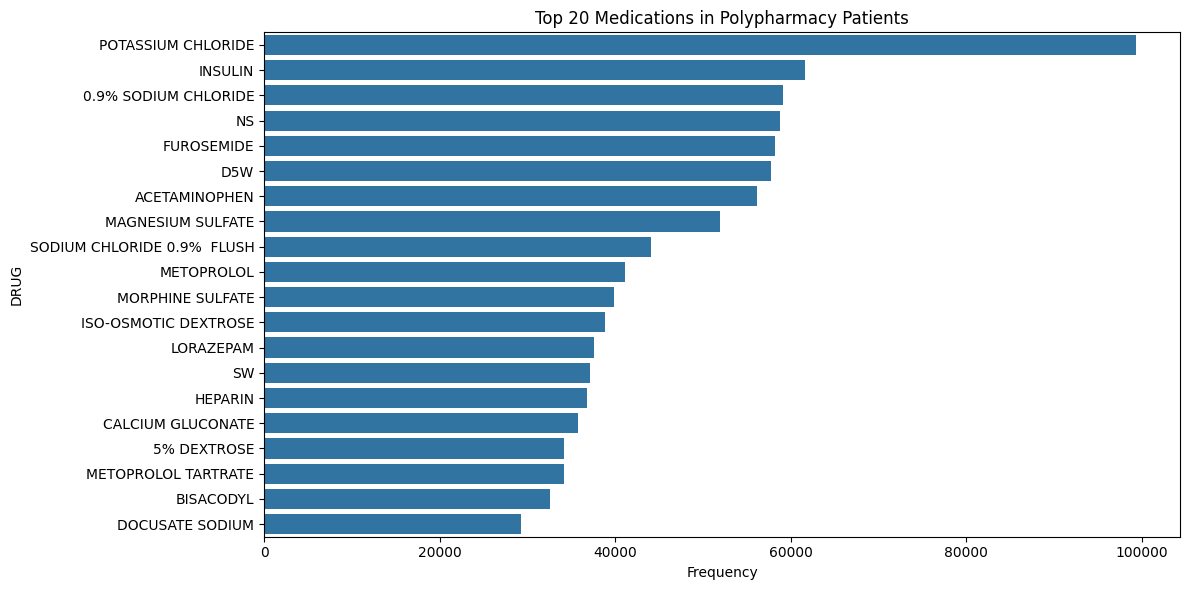

In [11]:
# 5.1 Find the most common medications in polypharmacy patients
top_medications = poly_prescriptions['DRUG'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_medications.values, y=top_medications.index)
plt.title('Top 20 Medications in Polypharmacy Patients')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

## Step 6: Build the Heterogeneous Graph

In [16]:
# 6.1 Create mappings for entities (patients, medications, diagnoses)

# First ensure we only work with patients that appear in all datasets
common_patients = set(poly_demographics['SUBJECT_ID']).intersection(
    set(poly_prescriptions['SUBJECT_ID'])).intersection(
    set(poly_diagnoses['SUBJECT_ID']))

print(f"Number of common patients across all datasets: {len(common_patients)}")

# Filter dataframes to include only common patients
poly_demographics = poly_demographics[poly_demographics['SUBJECT_ID'].isin(common_patients)]
poly_prescriptions = poly_prescriptions[poly_prescriptions['SUBJECT_ID'].isin(common_patients)]
poly_diagnoses = poly_diagnoses[poly_diagnoses['SUBJECT_ID'].isin(common_patients)]

# Now create the mappings with consistent patients
patient_mapping = {id_: idx for idx, id_ in enumerate(poly_demographics['SUBJECT_ID'].unique())}
medication_mapping = {med: idx for idx, med in enumerate(poly_prescriptions['DRUG'].unique())}
diagnosis_mapping = {diag: idx for idx, diag in enumerate(poly_diagnoses['ICD9_CODE'].unique())}

# Print the number of entities
print(f"\nGraph Entities:")
print(f"Patients: {len(patient_mapping)}")
print(f"Medications: {len(medication_mapping)}")
print(f"Diagnoses: {len(diagnosis_mapping)}")

# 6.2 Create edges between entities
# Patient-Medication edges
patient_med_edges = poly_prescriptions[['SUBJECT_ID', 'DRUG']].drop_duplicates()
# Safe version of edge creation
patient_med_src = []
patient_med_dst = []
for _, row in patient_med_edges.iterrows():
    if row['SUBJECT_ID'] in patient_mapping and row['DRUG'] in medication_mapping:
        patient_med_src.append(patient_mapping[row['SUBJECT_ID']])
        patient_med_dst.append(medication_mapping[row['DRUG']])

# Patient-Diagnosis edges
patient_diag_edges = poly_diagnoses[['SUBJECT_ID', 'ICD9_CODE']].drop_duplicates()
# Safe version
patient_diag_src = []
patient_diag_dst = []
for _, row in patient_diag_edges.iterrows():
    if row['SUBJECT_ID'] in patient_mapping and row['ICD9_CODE'] in diagnosis_mapping:
        patient_diag_src.append(patient_mapping[row['SUBJECT_ID']])
        patient_diag_dst.append(diagnosis_mapping[row['ICD9_CODE']])

# Medication-Medication edges (based on co-occurrence)
# First, we need to find medication co-occurrences
admission_meds = poly_prescriptions.groupby('HADM_ID')['DRUG'].apply(set).to_dict()

# Count co-occurrences
med_pairs = {}
for meds in admission_meds.values():
    meds_list = list(meds)
    for i in range(len(meds_list)):
        for j in range(i+1, len(meds_list)):
            pair = tuple(sorted([meds_list[i], meds_list[j]]))
            if pair in med_pairs:
                med_pairs[pair] += 1
            else:
                med_pairs[pair] = 1

# Create the edges safely
med_med_src = []
med_med_dst = []
med_med_weight = []
for (med1, med2), count in med_pairs.items():
    if med1 in medication_mapping and med2 in medication_mapping:
        med_med_src.append(medication_mapping[med1])
        med_med_dst.append(medication_mapping[med2])
        med_med_weight.append(count)
        # Add reverse edge for undirected graph
        med_med_src.append(medication_mapping[med2])
        med_med_dst.append(medication_mapping[med1])
        med_med_weight.append(count)

# Print the number of edges
print(f"\nGraph Edges:")
print(f"Patient-Medication: {len(patient_med_src)}")
print(f"Patient-Diagnosis: {len(patient_diag_src)}")
print(f"Medication-Medication: {len(med_med_src) // 2}")  # Divide by 2 since we added both directions

# Check if we have edges to work with
if len(patient_med_src) == 0 or len(patient_diag_src) == 0:
    print("\nWARNING: No edges found. Please check your data filtering steps.")
    # If no edges, create a minimal example to avoid errors
    if len(patient_med_src) == 0 and len(patient_mapping) > 0 and len(medication_mapping) > 0:
        print("Creating a minimal example for patient-medication edges.")
        patient_id = list(patient_mapping.keys())[0]
        med_id = list(medication_mapping.keys())[0]
        patient_med_src = [patient_mapping[patient_id]]
        patient_med_dst = [medication_mapping[med_id]]

# 6.3 Create PyTorch Geometric heterogeneous graph
data = HeteroData()

# Add node features
# For simplicity, we'll use one-hot encoding as node features
data['patient'].x = torch.eye(len(patient_mapping))
data['medication'].x = torch.eye(len(medication_mapping))
data['diagnosis'].x = torch.eye(len(diagnosis_mapping))

# Add edges
data['patient', 'takes', 'medication'].edge_index = torch.tensor([patient_med_src, patient_med_dst], dtype=torch.long)
data['patient', 'has', 'diagnosis'].edge_index = torch.tensor([patient_diag_src, patient_diag_dst], dtype=torch.long)
data['medication', 'co_occurs_with', 'medication'].edge_index = torch.tensor([med_med_src, med_med_dst], dtype=torch.long)
data['medication', 'co_occurs_with', 'medication'].edge_attr = torch.tensor(med_med_weight, dtype=torch.float).reshape(-1, 1)

print("\nHeterogeneous Graph Data:")
print(data)

Number of common patients across all datasets: 35976

Graph Entities:
Patients: 35976
Medications: 3818
Diagnoses: 6749

Graph Edges:
Patient-Medication: 1471678
Patient-Diagnosis: 503484
Medication-Medication: 637859

Heterogeneous Graph Data:
HeteroData(
  patient={ x=[35976, 35976] },
  medication={ x=[3818, 3818] },
  diagnosis={ x=[6749, 6749] },
  (patient, takes, medication)={ edge_index=[2, 1471678] },
  (patient, has, diagnosis)={ edge_index=[2, 503484] },
  (medication, co_occurs_with, medication)={
    edge_index=[2, 1275718],
    edge_attr=[1275718, 1],
  }
)


## Step 7: Create Training Data for Medication Recommendation


In [17]:
# 7.1 Split patient-medication edges for training
# We'll remove some medication edges and try to predict them
edge_index = data['patient', 'takes', 'medication'].edge_index
num_edges = edge_index.size(1)

# Create a mask for splitting edges
train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)

# Randomly split edges: 70% train, 15% validation, 15% test
indices = torch.randperm(num_edges)
train_size = int(0.7 * num_edges)
val_size = int(0.15 * num_edges)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Store the split masks
data['patient', 'takes', 'medication'].train_mask = train_mask
data['patient', 'takes', 'medication'].val_mask = val_mask
data['patient', 'takes', 'medication'].test_mask = test_mask

# 7.2 Create negative samples for training
# For each positive edge, we'll create a negative edge (patient-medication pair that doesn't exist)
def sample_negative_edges(edge_index, num_nodes_src, num_nodes_dst, num_samples):
    # Create a set of all positive edges for efficient lookup
    pos_edges = set([(src.item(), dst.item()) for src, dst in zip(*edge_index)])

    neg_src = []
    neg_dst = []
    count = 0

    while count < num_samples:
        # Randomly sample source and destination nodes
        src = torch.randint(0, num_nodes_src, (1,)).item()
        dst = torch.randint(0, num_nodes_dst, (1,)).item()

        # Check if this edge doesn't exist
        if (src, dst) not in pos_edges:
            neg_src.append(src)
            neg_dst.append(dst)
            count += 1

    return torch.tensor([neg_src, neg_dst], dtype=torch.long)

# Generate negative edges for training, validation, and testing
num_patients = data['patient'].x.size(0)
num_medications = data['medication'].x.size(0)

# Generate the same number of negative edges as positive edges for each split
train_neg_edge_index = sample_negative_edges(
    data['patient', 'takes', 'medication'].edge_index[:, train_mask],
    num_patients,
    num_medications,
    train_mask.sum().item()
)

val_neg_edge_index = sample_negative_edges(
    data['patient', 'takes', 'medication'].edge_index[:, val_mask],
    num_patients,
    num_medications,
    val_mask.sum().item()
)

test_neg_edge_index = sample_negative_edges(
    data['patient', 'takes', 'medication'].edge_index[:, test_mask],
    num_patients,
    num_medications,
    test_mask.sum().item()
)

# Store negative edges
data['patient', 'takes', 'medication'].train_neg_edge_index = train_neg_edge_index
data['patient', 'takes', 'medication'].val_neg_edge_index = val_neg_edge_index
data['patient', 'takes', 'medication'].test_neg_edge_index = test_neg_edge_index

print("\nTraining Data Preparation:")
print(f"Positive train edges: {train_mask.sum().item()}")
print(f"Positive validation edges: {val_mask.sum().item()}")
print(f"Positive test edges: {test_mask.sum().item()}")
print(f"Negative train edges: {train_neg_edge_index.size(1)}")
print(f"Negative validation edges: {val_neg_edge_index.size(1)}")
print(f"Negative test edges: {test_neg_edge_index.size(1)}")


Training Data Preparation:
Positive train edges: 1030174
Positive validation edges: 220751
Positive test edges: 220753
Negative train edges: 1030174
Negative validation edges: 220751
Negative test edges: 220753


## Step 8: Design the Graph Neural Network Model


In [24]:
## Step 8: Design the Graph Neural Network Model
# 8.1 Define a simpler GNN model for heterogeneous graphs
import torch
from torch_geometric.nn import SAGEConv, HeteroConv, GATConv, Linear

class SimpleHeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()

        # Extract node types and edge types from metadata
        node_types, edge_types = metadata

        # First layer of convolutions
        self.conv1 = HeteroConv({
            ('patient', 'takes', 'medication'): SAGEConv((-1, -1), hidden_channels, aggr='mean'),
            ('patient', 'has', 'diagnosis'): SAGEConv((-1, -1), hidden_channels, aggr='mean'),
            ('medication', 'co_occurs_with', 'medication'): SAGEConv((-1, -1), hidden_channels, aggr='mean'),
        }, aggr='sum')

        # Second layer of convolutions
        self.conv2 = HeteroConv({
            ('patient', 'takes', 'medication'): SAGEConv((-1, -1), out_channels, aggr='mean'),
            ('patient', 'has', 'diagnosis'): SAGEConv((-1, -1), out_channels, aggr='mean'),
            ('medication', 'co_occurs_with', 'medication'): SAGEConv((-1, -1), out_channels, aggr='mean'),
        }, aggr='sum')

        # Linear transformations for each node type
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        # Link predictor for patient-medication pairs
        self.link_predictor = torch.nn.Sequential(
            torch.nn.Linear(out_channels * 2, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1)
        )

    def forward(self, x_dict, edge_index_dict):
        # Initial linear transformation for each node type
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x)

        # First convolution layer
        x_dict = self.conv1(x_dict, edge_index_dict)

        # Apply ReLU activation explicitly for each node type
        for node_type in x_dict.keys():
            x_dict[node_type] = F.relu(x_dict[node_type])

        # Second convolution layer
        x_dict = self.conv2(x_dict, edge_index_dict)

        return x_dict

    def predict_links(self, x_dict, edge_index):
        # Extract node embeddings for source (patient) and destination (medication)
        patient_embeddings = x_dict['patient'][edge_index[0]]
        medication_embeddings = x_dict['medication'][edge_index[1]]

        # Concatenate embeddings and predict link
        x = torch.cat([patient_embeddings, medication_embeddings], dim=-1)
        return self.link_predictor(x).squeeze(-1)

# 8.2 Initialize the model
hidden_channels = 64
out_channels = 32

# Get metadata from the graph
metadata = data.metadata()
print(f"Graph metadata: {metadata}")

# Create the model
model = SimpleHeteroGNN(hidden_channels, out_channels, metadata)

print("\nModel Architecture:")
print(model)

Graph metadata: (['patient', 'medication', 'diagnosis'], [('patient', 'takes', 'medication'), ('patient', 'has', 'diagnosis'), ('medication', 'co_occurs_with', 'medication')])

Model Architecture:
SimpleHeteroGNN(
  (conv1): HeteroConv(num_relations=3)
  (conv2): HeteroConv(num_relations=3)
  (lin_dict): ModuleDict(
    (patient): Linear(-1, 64, bias=True)
    (medication): Linear(-1, 64, bias=True)
    (diagnosis): Linear(-1, 64, bias=True)
  )
  (link_predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)



## Step 9: Train the Model

In [25]:
# 9.1 Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 9.2 Define the training function
def train():
    model.train()
    optimizer.zero_grad()

    # Encode all nodes
    node_embeddings = model(data.x_dict, data.edge_index_dict)

    # Edge prediction for positive examples
    train_pos_edge_index = data['patient', 'takes', 'medication'].edge_index[:, train_mask]
    pos_pred = model.predict_links(node_embeddings, train_pos_edge_index)

    # Edge prediction for negative examples
    train_neg_edge_index = data['patient', 'takes', 'medication'].train_neg_edge_index
    neg_pred = model.predict_links(node_embeddings, train_neg_edge_index)

    # Binary cross entropy loss
    pos_loss = F.binary_cross_entropy_with_logits(pos_pred, torch.ones_like(pos_pred))
    neg_loss = F.binary_cross_entropy_with_logits(neg_pred, torch.zeros_like(neg_pred))
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    return float(loss)

# 9.3 Define the evaluation function
@torch.no_grad()
def evaluate(edge_index_pos, edge_index_neg):
    model.eval()

    # Encode all nodes
    node_embeddings = model(data.x_dict, data.edge_index_dict)

    # Edge prediction for positive and negative examples
    pos_pred = model.predict_links(node_embeddings, edge_index_pos)
    neg_pred = model.predict_links(node_embeddings, edge_index_neg)

    # Combine predictions and true labels
    pred = torch.cat([pos_pred, neg_pred], dim=0)
    true = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)], dim=0)

    # Calculate evaluation metrics
    auc = roc_auc_score(true.cpu().numpy(), pred.cpu().numpy())

    # Calculate F1 score
    pred_binary = (pred > 0.0).float()
    f1 = f1_score(true.cpu().numpy(), pred_binary.cpu().numpy())

    return auc, f1

# 9.4 Train the model
print("\nTraining the Model:")
n_epochs = 100
best_val_auc = 0.0
best_model_state = None

for epoch in range(1, n_epochs + 1):
    loss = train()

    # Evaluate on validation set
    val_edge_index_pos = data['patient', 'takes', 'medication'].edge_index[:, val_mask]
    val_edge_index_neg = data['patient', 'takes', 'medication'].val_neg_edge_index
    val_auc, val_f1 = evaluate(val_edge_index_pos, val_edge_index_neg)

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = {key: value.cpu().clone() for key, value in model.state_dict().items()}

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}")

# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
test_edge_index_pos = data['patient', 'takes', 'medication'].edge_index[:, test_mask]
test_edge_index_neg = data['patient', 'takes', 'medication'].test_neg_edge_index
test_auc, test_f1 = evaluate(test_edge_index_pos, test_edge_index_neg)

print(f"\nTest AUC: {test_auc:.4f}, Test F1: {test_f1:.4f}")


Training the Model:


AttributeError: 'NoneType' object has no attribute 'dim'

## Step 13: Case Study with Multiple Patients


In [14]:
# 13.1 Compare recommendations for multiple patients
def compare_patient_recommendations(patient_ids, top_k=5):
    """
    Compare medication recommendations for multiple patients
    """
    results = {}

    for patient_id in patient_ids:
        if patient_id not in patient_mapping:
            print(f"Patient ID {patient_id} not found in the dataset.")
            continue

        # Get actual medications
        actual_meds = poly_prescriptions[
            poly_prescriptions['SUBJECT_ID'] == patient_id
        ]['DRUG'].unique()

        # Get recommendations
        recommendations = recommend_medications(patient_id, top_k=top_k)
        recommended_meds = [med for med, _ in recommendations]

        # Calculate overlap
        overlap = set(actual_meds).intersection(set(recommended_meds))
        overlap_count = len(overlap)
        overlap_percentage = (overlap_count / len(actual_meds)) * 100 if len(actual_meds) > 0 else 0

        results[patient_id] = {
            'actual_meds': actual_meds,
            'recommended_meds': recommended_meds,
            'overlap_meds': list(overlap),
            'overlap_count': overlap_count,
            'overlap_percentage': overlap_percentage
        }

    return results

# 13.2 Select a few sample patients for comparison
# Get a random sample of 5 patient IDs
sample_patient_ids = list(patient_mapping.keys())[:5]

# Get recommendations and comparisons
comparison_results = compare_patient_recommendations(sample_patient_ids)

# 13.3 Visualize comparison results
plt.figure(figsize=(12, 6))
patient_ids = list(comparison_results.keys())
overlap_percentages = [results['overlap_percentage'] for results in comparison_results.values()]

plt.bar(patient_ids, overlap_percentages)
plt.title('Recommendation Accuracy: Overlap with Actual Medications')
plt.xlabel('Patient ID')
plt.ylabel('Overlap Percentage (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 13.4 Display detailed comparison for one patient
sample_id = patient_ids[0]
print(f"\nDetailed Comparison for Patient {sample_id}:")
print(f"Actual medications ({len(comparison_results[sample_id]['actual_meds'])}):")
for med in comparison_results[sample_id]['actual_meds']:
    print(f"- {med}")

print(f"\nRecommended medications ({len(comparison_results[sample_id]['recommended_meds'])}):")
for med in comparison_results[sample_id]['recommended_meds']:
    if med in comparison_results[sample_id]['overlap_meds']:
        print(f"- {med} (✓)")
    else:
        print(f"- {med}")

print(f"\nOverlap: {comparison_results[sample_id]['overlap_count']} medications")
print(f"Overlap percentage: {comparison_results[sample_id]['overlap_percentage']:.2f}%")

NameError: name 'patient_mapping' is not defined